# Import Packages

In [1]:
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define Directories and Filenames
One needs to have the L0 file KP.20221112.26598.92_L1.fits in the data/ directory of the folder from which this notebook is running.  This file can be downloaded from Jump or shrek.caltech.edu.  One can also modify the code below to work with other files or paths.

In [2]:
L1_data_dir = 'data/'
ObsID = 'KP.20221112.26598.92' # Commissioning Spectrum of 51 Pegasi
L1_file = L1_data_dir + ObsID + '_L1.fits'

# Open File and Show Information
Note that there are exensions for:
  * Header keywords (PRIMARY) - all of the header keywords from the corrssponding L0 file plus ones created during DRP processin that produced the L1
  * The receipt detailing the DRP operations that produced this L1 file (RECEIPT)
  * A list of configuration variables that were set when the DRP produced this L1 file (CONFIG).  This feature is not yet implemented.
  * Telemetry of the KPF instrument from the L0 file (TELEMETRY)
  * Extracted spectra from the green and red CCDs.  There are 35 spectral orders on the green CCD (445-600 nm) and 32 spectral orders on the red CCD (600-870 nm).  Each order has five orderlers derived from the three KPF fibers (SKY, SCI, CAL).  Spatially, the orderlets are arrayed {SKY, SCI1, SCI2, SCI3, CAL} from bottom (lower cross dispersion wavelengths) to top on the CCDs.  The extracted spectra are stored in units of photoelectrons, which is corrected for CCD gain and obeys Poisson statistics.  The extracted sectra are organized as one-dimensional flux arrays of length 4080 for each of the 35 or 32 orders:
      * three orderlets from the SCI fiber (GREEN_SCI_FLUX1, GREEN_SCI_FLUX2, GREEN_SCI_FLUX3, RED_SCI_FLUX1, RED_SCI_FLUX2, RED_SCI_FLUX3), 
      * one SKY fiber orderlet (GREEN_SKY_FLUX, RED_SKY_FLUX)
      * one CAL fiber orderlet (GREEN_CAL_FLUX, RED_CAL_FLUX) per spectral order.  
  * Each extracted pixel has a corresponding variance (GREEN_SCI_VAR1, GREEN_SCI_VAR2, GREEN_SCI_VAR3, GREEN_SKY_VAR3, GREEN_CAL_VAR3, RED_SCI_VAR1, RED_SCI_VAR2, RED_SCI_VAR3, RED_SKY_VAR3, RED_CAL_VAR3) and wavelength (GREEN_SCI_WAV1, GREEN_SCI_WAV2, GREEN_SCI_WAV3, GREEN_SKY_WAV3, GREEN_CAL_WAV3, RED_SCI_WAV1, RED_SCI_WAV2, RED_SCI_WAV3, RED_SKY_VAR3, RED_CAL_VAR3).
  * Telluric models of the green and red spectra (GREEN_TELLURIC and RED_TELLURIC), which are currently not populated.
  * Sky models of the green and red spectra (GREEN_SKY and RED_SKY), which are currently not populated.
  * Extracted spectra of the science and sky traces (seven orders each) from the Ca H&K spectometer (CA_HK_SCI and CA_HK_SKY)
  * Wavelength solutions from the Ca H&K spectra (CA_HK_WAV and CA_HK_WAV)

In [3]:
L1 = fits.open(L1_file)
L1.info()

Filename: data/KP.20221112.26598.92_L1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     303   ()      
  1  RECEIPT       1 BinTableHDU     29   12R x 10C   [26A, 6A, 7A, 40A, 3A, 18A, 1A, 51A, 87A, 4A]   
  2  CONFIG        1 BinTableHDU     13   0R x 2C   [D, D]   
  3  TELEMETRY     1 BinTableHDU      9   0R x 0C   []   
  4  GREEN_SCI_FLUX1    1 ImageHDU        13   (4080, 35)   float64   
  5  GREEN_SCI_FLUX2    1 ImageHDU        13   (4080, 35)   float64   
  6  GREEN_SCI_FLUX3    1 ImageHDU        13   (4080, 35)   float64   
  7  GREEN_SKY_FLUX    1 ImageHDU        13   (4080, 35)   float64   
  8  GREEN_CAL_FLUX    1 ImageHDU        13   (4080, 35)   float64   
  9  GREEN_SCI_VAR1    1 ImageHDU         8   (4080, 35)   float64   
 10  GREEN_SCI_VAR2    1 ImageHDU         8   (4080, 35)   float64   
 11  GREEN_SCI_VAR3    1 ImageHDU         8   (4080, 35)   float64   
 12  GREEN_SKY_VAR    1 ImageHDU         8   (4080, 35)  

# Receipt
The receipt is a FITS binary table that is converted below to a Pandas dataframe.  The receipt contains a time-ordered list of DRP modules and associated parameteres that were used to produce the L1 file as well as other related information

In [4]:
df_receipt = Table.read(L1_file, format='fits',hdu='RECEIPT').to_pandas()
num_columns = ['Module_Level']
for column in df_receipt:
    df_receipt[column] = df_receipt[column].str.decode('utf-8')
    if column in num_columns:
        df_receipt[column] = pd.to_numeric(df_receipt[column], downcast="float")
    else:
        df_receipt[column] = df_receipt[column].astype(str)
df_receipt

,Time,Code_Release,Branch_Name,Commit_Hash,Chip,Module_Name,Module_Level,Module_Path,Module_Param,Status
0,2022-12-02T22:34:20.793957,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,SpectralExtraction,1.0,modules.spectral_extraction.src.spectral_extra...,orderlets=GREEN_SKY_FLUX GREEN_SCI_FLUX1 GREEN...,PASS
1,2022-12-02T22:34:21.931624,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:GREEN_SC...,PASS
2,2022-12-02T22:34:22.393367,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:GREEN_SC...,PASS
3,2022-12-02T22:34:22.867832,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:GREEN_SC...,PASS
4,2022-12-02T22:34:23.348420,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:GREEN_SK...,PASS
5,2022-12-02T22:34:23.834707,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:GREEN_CA...,PASS
6,2022-12-02T22:34:44.166094,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,SpectralExtraction,1.0,modules.spectral_extraction.src.spectral_extra...,orderlets=RED_SKY_FLUX RED_SCI_FLUX1 RED_SCI_F...,PASS
7,2022-12-02T22:34:45.521302,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:RED_SCI_...,PASS
8,2022-12-02T22:34:46.070033,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:RED_SCI_...,PASS
9,2022-12-02T22:34:46.614998,v2.0.1,develop,47d149b892ae6cd4980a204fef3ae6f1cb3bb6fa,all,ExtCopy,1.0,modules.Utils.data_handler,extension copy from MasterLFCWLS.fits:RED_SCI_...,PASS


# Extracted Spectra
We will start by plotting spectra from the SCI2 trace on both CCDs

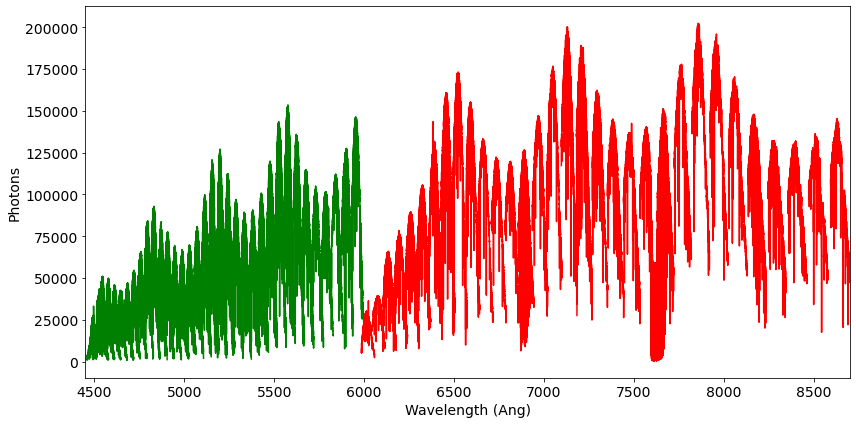

In [5]:
plt.figure(figsize=(12, 6), tight_layout=True)
for o in range(35):
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_FLUX2'].data[o,:], color='g')
for o in range(32):
    plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_FLUX2'].data[o,:], color='r')
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Photons', fontsize=14)
plt.xlim(4450,8700)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now we will plot just order 16 on the red CCD for the SCI2 trace.

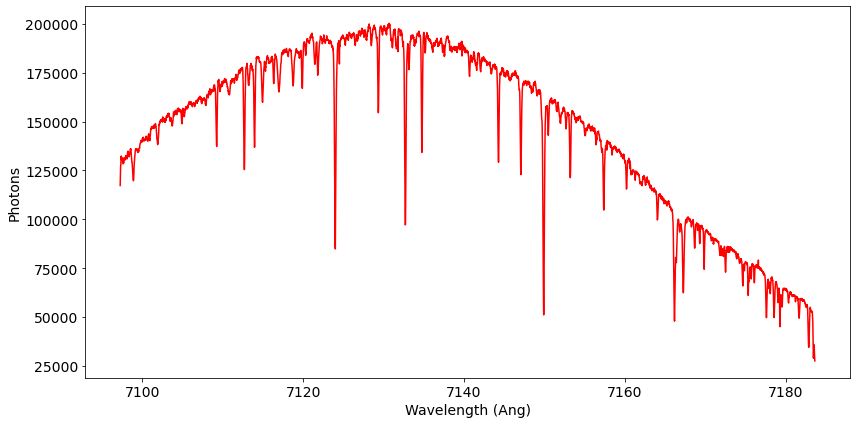

In [6]:
plt.figure(figsize=(12, 6), tight_layout=True)
o = 16
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_FLUX2'].data[o,:], color='r')
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Photons', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The SCI1, SCI2, and SCI3 have different amounts of flux because they come from different parts of the sliced octagonal SCI fiber.

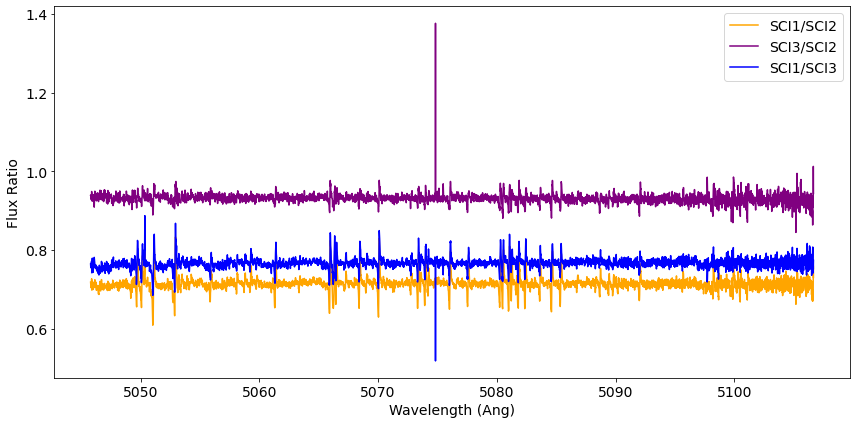

In [7]:
plt.figure(figsize=(12, 6), tight_layout=True)
o = 16
plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_FLUX1'].data[o,:]/L1['GREEN_SCI_FLUX2'].data[o,:], color='orange')
plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_FLUX3'].data[o,:]/L1['GREEN_SCI_FLUX2'].data[o,:], color='purple')
plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_FLUX1'].data[o,:]/L1['GREEN_SCI_FLUX3'].data[o,:], color='blue')
plt.legend(['SCI1/SCI2', 'SCI3/SCI2', 'SCI1/SCI3'], fontsize=14, loc='best') 
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Flux Ratio', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

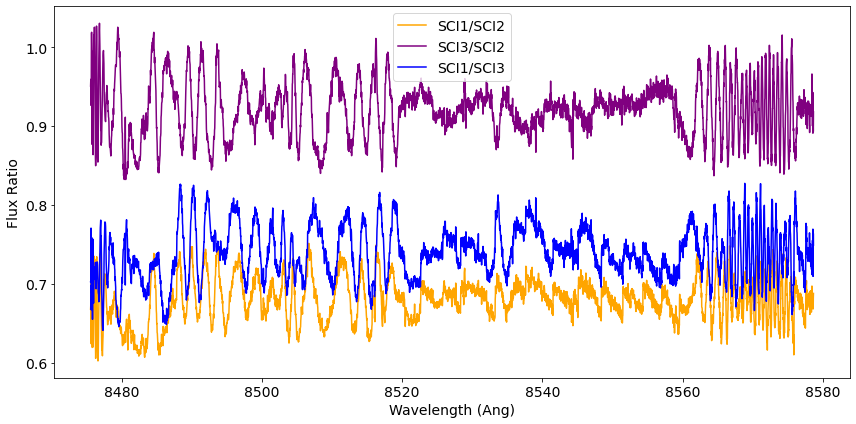

In [8]:
plt.figure(figsize=(12, 6), tight_layout=True)
o = 30
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_FLUX1'].data[o,:]/L1['RED_SCI_FLUX2'].data[o,:], color='orange')
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_FLUX3'].data[o,:]/L1['RED_SCI_FLUX2'].data[o,:], color='purple')
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_FLUX1'].data[o,:]/L1['RED_SCI_FLUX3'].data[o,:], color='blue')
plt.legend(['SCI1/SCI2', 'SCI3/SCI2', 'SCI1/SCI3'], fontsize=14, loc='best') 
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Flux Ratio', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The wavelength solutions for the different SCI orderlets are similar, but not identical.

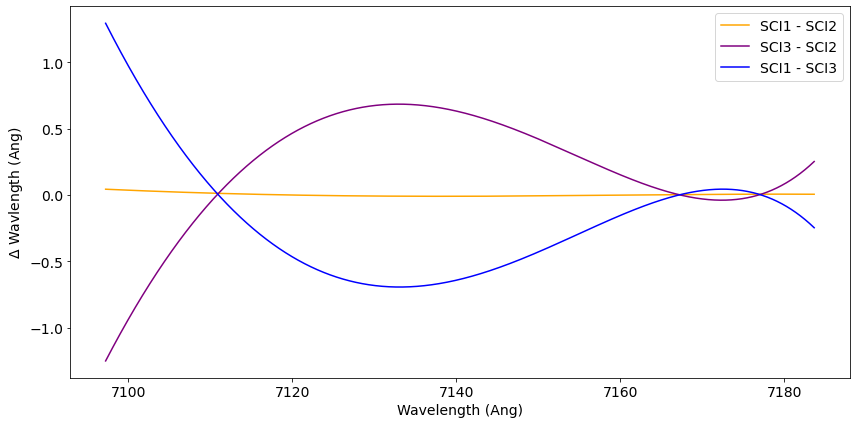

In [9]:
plt.figure(figsize=(12, 6), tight_layout=True)
o = 16
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE1'].data[o,:] - L1['RED_SCI_WAVE2'].data[o,:], color='orange')
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE3'].data[o,:] - L1['RED_SCI_WAVE2'].data[o,:], color='purple')
plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE1'].data[o,:] - L1['RED_SCI_WAVE3'].data[o,:], color='blue')
plt.legend(['SCI1 - SCI2', 'SCI3 - SCI2', 'SCI1 - SCI3'], fontsize=14, loc='best') 
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel(r'$\Delta$ Wavlength (Ang)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The size of a pixel in Angstroms is:

In [10]:
L1['RED_SCI_WAVE1'].data[o,1999]  - L1['RED_SCI_WAVE1'].data[o,2000] 

0.021120196752235643

Zooming out and plotting the wavelength difference for all orders.

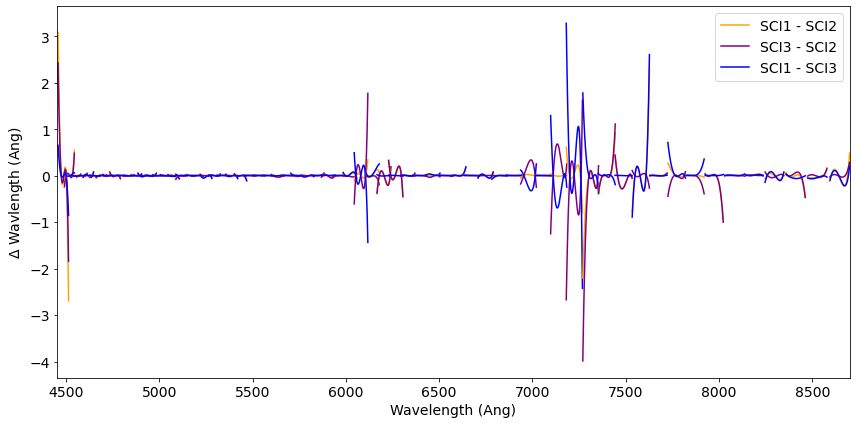

In [11]:
plt.figure(figsize=(12, 6), tight_layout=True)
for o in range(35):
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_WAVE1'].data[o,:] - L1['GREEN_SCI_WAVE2'].data[o,:], color='orange')
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_WAVE3'].data[o,:] - L1['GREEN_SCI_WAVE2'].data[o,:], color='purple')
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], L1['GREEN_SCI_WAVE1'].data[o,:] - L1['GREEN_SCI_WAVE3'].data[o,:], color='blue')
for o in range(32):
    plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE1'].data[o,:] - L1['RED_SCI_WAVE2'].data[o,:], color='orange')
    plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE3'].data[o,:] - L1['RED_SCI_WAVE2'].data[o,:], color='purple')
    plt.plot(L1['RED_SCI_WAVE2'].data[o,:], L1['RED_SCI_WAVE1'].data[o,:] - L1['RED_SCI_WAVE3'].data[o,:], color='blue')
plt.legend(['SCI1 - SCI2', 'SCI3 - SCI2', 'SCI1 - SCI3'], fontsize=14, loc='best') 
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel(r'$\Delta$ Wavlength (Ang)', fontsize=14)
plt.xlim(4450,8700)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can also plot the sky spectrum, which in the current case looks like mostly scattered light since there are no visible spectral lines.

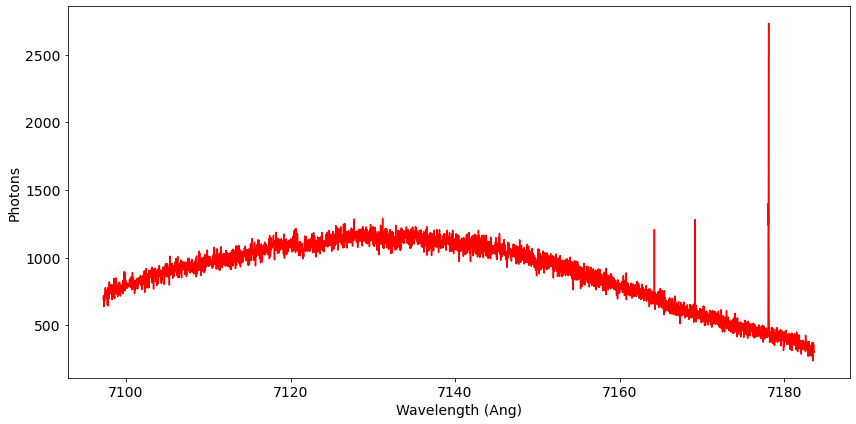

In [12]:
plt.figure(figsize=(12, 6), tight_layout=True)
o = 16
plt.plot(L1['RED_SKY_WAVE'].data[o,:], L1['RED_SKY_FLUX'].data[o,:], color='r')
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Photons', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Variance allows us to compute the SNR of the spectrum.  At the moment, only Poisson noise is included in the variance.  Read noise and dark current are not.  Here we will add the flux (and variance) from the three SCI orderlets.  Let's also plot the median SNR per order.

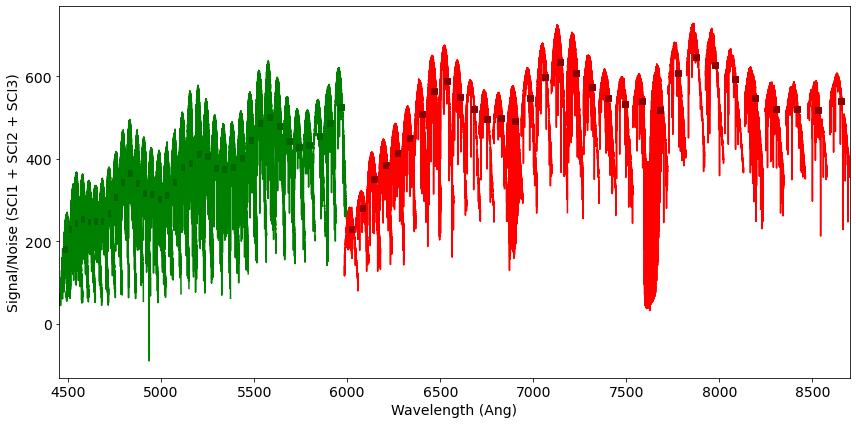

In [13]:
GREEN_SCI_FLUX = L1['GREEN_SCI_FLUX1'].data + L1['GREEN_SCI_FLUX2'].data + L1['GREEN_SCI_FLUX3'].data
RED_SCI_FLUX   = L1['RED_SCI_FLUX1'].data   + L1['RED_SCI_FLUX2'].data   + L1['RED_SCI_FLUX3'].data
GREEN_SCI_VAR  = L1['GREEN_SCI_VAR1'].data  + L1['GREEN_SCI_VAR2'].data  + L1['GREEN_SCI_VAR3'].data
RED_SCI_VAR    = L1['RED_SCI_VAR1'].data    + L1['RED_SCI_VAR2'].data    + L1['RED_SCI_VAR3'].data

plt.figure(figsize=(12, 6), tight_layout=True)
for o in range(35):
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,:], GREEN_SCI_FLUX[o,:]/np.sqrt(GREEN_SCI_VAR[o,:]), color='g')
    plt.plot(L1['GREEN_SCI_WAVE2'].data[o,2040], np.median(GREEN_SCI_FLUX[o,:]/np.sqrt(GREEN_SCI_VAR[o,:])), marker="s", color='darkgreen')
for o in range(32):
    plt.plot(L1['RED_SCI_WAVE2'].data[o,:], RED_SCI_FLUX[o,:]/np.sqrt(RED_SCI_VAR[o,:]), color='r')
    plt.plot(L1['RED_SCI_WAVE2'].data[o,2040], np.median(RED_SCI_FLUX[o,:]/np.sqrt(RED_SCI_VAR[o,:])), marker="s", color='darkred')
plt.xlabel('Wavelength (Ang)', fontsize=14)
plt.ylabel('Signal/Noise (SCI1 + SCI2 + SCI3)', fontsize=14)
plt.xlim(4450,8700)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()